In [1]:
import numpy as np
import pandas as pd #to work with csv files

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

#import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words
#pre-processing of text
import string
import re
from gensim.models import Word2Vec, KeyedVectors
import gensim
import gensim.downloader as gensim_api
#import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

#import time function from time module to track the training duration
from time import time
from collections import OrderedDict

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import OrderedDict

In [2]:
tweets = pd.read_csv('COVID19_Dataset-text_labels_only.csv')

In [3]:
tweets

Is_Unreliable    Category  \
0                1  1, 3, 6, 9   
1                1  1, 6, 8, 9   
2                1     1, 4, 9   
3                1        6, 8   
4                1     6, 8, 9   
..             ...         ...   
555              0         NaN   
556              0         NaN   
557              0         NaN   
558              0         NaN   
559              0         NaN   

                                                 Tweet  
0    We are living in scary times in Canada. Gov’t ...  
1    Just as bad in Canada. In fact, our government...  
2    It was only a matter of time before the mainst...  
3    Russia's taking no chances: Foreigners infecte...  
4    Although there is now a presumptive confirmed ...  
..                                                 ...  
555  BREAKING: Harvard classes will move online sta...  
556  Singularity University is hosting a FREE Virtu...  
557  Coronavirus: how does it spread and what are t...  
558  Stanford just cancelled classes for the rest o...  
559  Tech conferences were cancelled in #Waterloo R...  

[560 rows x 3 columns]

In [4]:
def clean_text(str_list, lemmatize = True):
    clean_list = []
    
    for text in str_list:
        # to drop pound sign from hash tags
        text = re.sub(r'#', '', text)
        words = word_tokenize(text)
        clean_words = []
        
        for word in words:            
            # drop words with fewer than 2 characters; drop any punctuation "words"
            if (len(word) > 1) and (re.match(r'^\w+$', word)):

                if lemmatize==True:
                    lemmatizer=WordNetLemmatizer()
                    word1 = lemmatizer.lemmatize(word)
                    #if word!=word1:
                        #print(word1)
                        #print(word)
                    
                clean_words.append(word1)
        clean_text = ' '.join(clean_words)
        clean_list.append(clean_text)
    
    return clean_list

In [5]:
# run on all tweets
tweets['clean_tweet'] = clean_text(tweets['Tweet'])

In [6]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

#Step 1: train-test split
X = tweets['clean_tweet'] #the column text contains textual data to extract features from
y = tweets['Is_Unreliable'] #this is the column we are learning to predict. 

print(X.shape, y.shape)

#random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(560,) (560,)
(504,) (504,)
(56,) (56,)


In [7]:
#Train a classifier
vect = TfidfVectorizer(lowercase = True,
                        stop_words = 'english',
                        ngram_range = (1,1)) #instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)#combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LogisticRegression(class_weight='balanced') #instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

#Until here, it is the same code as earlier.

Accuracy:  0.7142857142857143


In [8]:
# select any tweet from the test set
index = 212
mystring = tweets.iloc[index,3]
mystring

'All this American hysteria over Coronavirus like these fucking aren in our backyard'

In [9]:
# Get the actual class of the tweet selected in the test set
true_class = tweets.iloc[index,0]
true_class

1

In [10]:
# k = ['5G technology and coronavirus vaccine are completely unrelated']

In [11]:
tweets["clean_tweet"][index]

'All this American hysteria over Coronavirus like these fucking aren in our backyard'

In [12]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
mystring = '5G technology and coronavirus vaccine are completely unrelated'
y_pred_prob = classifier.predict_proba(X_test_dtm)[:, 1]
c = make_pipeline(vect, classifier)
# mystring = list(X_test)[1] #Take a string from test instance
print(c.predict_proba([mystring]))
# actual = lambda x : 'unreliable' if x else 'reliable'
print(c.predict([mystring]))

print("Probability (Unreliable) =", c.predict_proba([mystring])[0, 1])
print("Probability (Reliable) =", c.predict_proba([mystring])[0, 0])
print("True Class is:", true_class)

[[0.34685373 0.65314627]]
[1]
Probability (Unreliable) = 0.6531462716468098
Probability (Reliable) = 0.34685372835319017
True Class is: 1


In [13]:
class_names = ["reliable", "unreliable"] 
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(mystring, c.predict_proba, num_features=6)
exp.as_list()

[('vaccine', 0.09734471666420921),
 ('5G', -0.026251135040685224),
 ('coronavirus', 0.013884765511945125),
 ('unrelated', 0.0010072318118998108),
 ('technology', 0.0009922030102451707),
 ('completely', 0.0009636453258042428)]

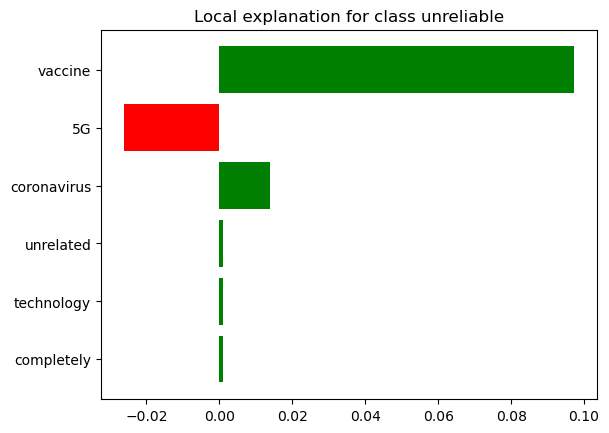

In [14]:
%matplotlib inline
fig = exp.as_pyplot_figure()

In [15]:
exp.show_in_notebook(text=mystring, labels=(1,))

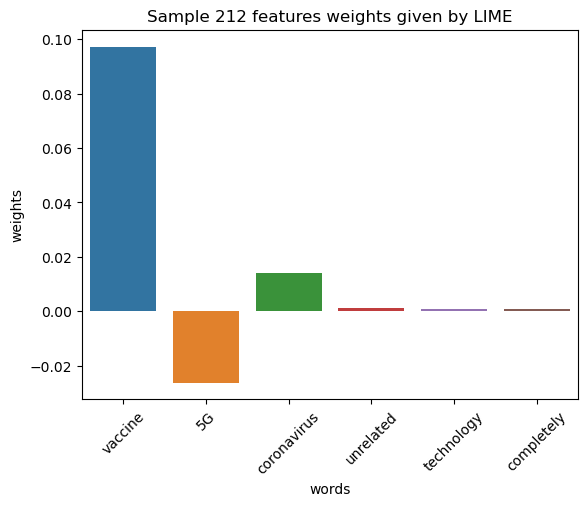

In [16]:
weights = OrderedDict(exp.as_list())
lime_weights = pd.DataFrame({"words": list(weights.keys()), "weights": list(weights.values())})

sns.barplot(x = "words", y = "weights", data = lime_weights)
plt.xticks(rotation = 45)
plt.title("Sample {} features weights given by LIME".format(index))
plt.show()

In [17]:
corpus = tweets["clean_tweet"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, delimiter=" ", min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], delimiter=" ", min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [18]:
# Train Word2Vec from scratch
avg_len = np.max([len(text.split()) for text in tweets["clean_tweet"]]) /2 
word2vec = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=300,   
            window=avg_len, min_count=1, sg=1, epochs=30)

In [19]:
class word2vecVectorizer:
    
    def __init__(self):
        
        # Train Word2Vec from scratch
        avg_len = np.max([len(text.split()) for text in tweets["clean_tweet"]]) /2
        word2vec = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=300,   
            window=avg_len, min_count=1, sg=1, epochs=30)
        self.word2vec = word2vec
        
        # Use pretrained embedding
#         word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
#         self.word2vec = word2vec
        
        self.vector_size = 300

    def fit(self, data, *args):
            pass
    def transform(self, data):
        X = []
        for sentence in data:
            tokens = nltk.word_tokenize(sentence)
            vecs = []
            for token in tokens:
                if token in self.word2vec.wv:
                    vec = self.word2vec.wv[token]
                    vecs.append(vec)
            if len(vecs) > 0:
                sentence_vec = np.mean(vecs, axis=0)
            else:
                sentence_vec = np.zeros((self.vector_size,), dtype=np.float32)
            X.append(sentence_vec)
        return np.array(X)


    def fit_transform(self, X, *args):
        self.fit(X, *args)
        return self.transform(X, *args)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [21]:
w2vec = word2vecVectorizer()

X_train = w2vec.fit_transform(X_train)
X_test = w2vec.transform(X_test)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(504, 300)
(56, 300)
(504,)
(56,)


In [22]:
classifier = LogisticRegression(class_weight='balanced') #instantiate a logistic regression model
classifier.fit(X_train, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = classifier.predict(X_test)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

#Until here, it is the same code as earlier.

Accuracy:  0.8035714285714286


In [23]:
# select any tweet from the test set
index = 212
mystring = tweets.iloc[index,3]
mystring

'All this American hysteria over Coronavirus like these fucking aren in our backyard'

In [24]:
# Get the actual class of the tweet selected in the test set
true_class = tweets.iloc[index,0]
true_class

1

In [25]:
tweets["clean_tweet"][index]

'All this American hysteria over Coronavirus like these fucking aren in our backyard'

In [26]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
# mystring = '5G technology and coronavirus vaccine are completely unrelated'
y_pred_prob = classifier.predict_proba(X_test)[:, 1]
c = make_pipeline(w2vec, classifier)
# mystring = list(X_test)[1] #Take a string from test instance
print(c.predict_proba([mystring]))
# actual = lambda x : 'unreliable' if x else 'reliable'
print(c.predict([mystring]))

print("Probability (Unreliable) =", c.predict_proba([mystring])[0, 1])
print("Probability (Reliable) =", c.predict_proba([mystring])[0, 0])
print("True Class is:", true_class)

[[0.29019477 0.70980523]]
[1]
Probability (Unreliable) = 0.7098052337028201
Probability (Reliable) = 0.2901947662971799
True Class is: 1


In [27]:
class_names = ["reliable", "unreliable"] 
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(mystring, c.predict_proba, num_features=6)
exp.as_list()

[('over', -0.17073891461559046),
 ('aren', 0.09345711631143333),
 ('this', 0.06906298116848134),
 ('in', -0.0689977196316073),
 ('fucking', 0.05397484572134067),
 ('these', 0.04860917767420006)]

In [28]:
exp.show_in_notebook(text=mystring, labels=(1,))

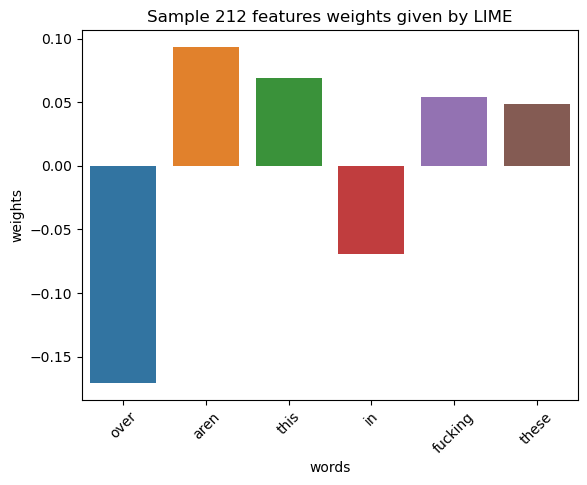

In [29]:
weights = OrderedDict(exp.as_list())
lime_weights = pd.DataFrame({"words": list(weights.keys()), "weights": list(weights.values())})

sns.barplot(x = "words", y = "weights", data = lime_weights)
plt.xticks(rotation = 45)
plt.title("Sample {} features weights given by LIME".format(index))
plt.show()

## Neural Networks and Deep Learning

#### Interpreting what CNNs learn

A fundamental problem when building a computer vision application is that of interpretability: why did your classifier think a particular image contained a fridge, when all you can see is a truck?

It is often said that deep learning models are "black boxes": they learn representations that are difficult to extract and present in a human-readable form. Although this is partially true for certain types of deep learning models, it is definitely not true for CNNs. The representations learned by CNNs are highly amenable to visualization, in large part because they are representations of visual concepts. Since 2013, a wide array of techniques has been developed for visualizing and interpreting these representations.

- **Visualizing intermediate CNN outputs (intermediate activations)**: Useful for understanding how successive CNN layers transform their input, and for getting a first idea of the meaning of individual CNN filters

- **Visualizing CNN filters**: Useful for understanding precisely what visual pattern or concept each filter in a CNN is receptive to

- **Visualizing heat-maps of class activation in an image**: Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images

## Visualizing intermediate activations

- Visualizing intermediate activations consists of displaying the values returned by various convolution and pooling layers in a model, given a certain input (the output of a layer is often called its activation,the output of the activation function).
- This gives a view into how an input is decomposed into the different filters learned by the network.
- We want to visualize feature maps with three dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.

In [30]:
from tensorflow import keras
model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

#### Preprocessing a single image

In [31]:
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

80329/80329 [==============================] - 0s 0us/step


#### Displaying the test picture

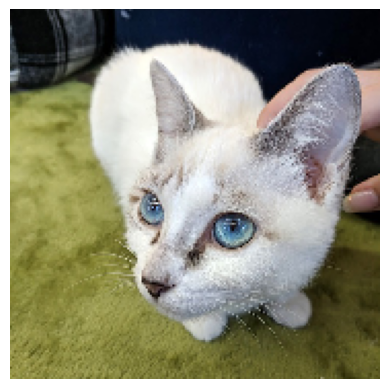

In [32]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

#### Instantiating a model that returns layer activations

In [33]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

#### Using the model to compute layer activations

In [34]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 1s 579ms/step


In [35]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


#### Visualizing the fifth channel

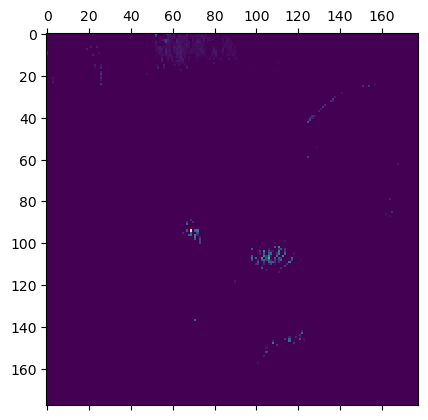

In [36]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

#### Visualizing every channel in every intermediate activation

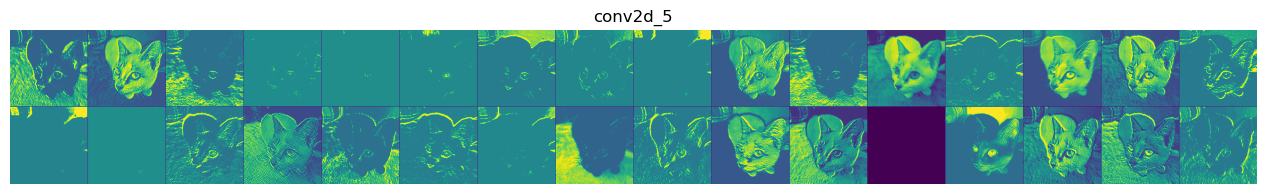

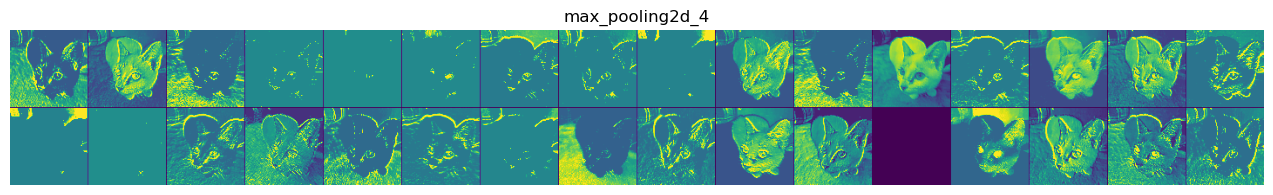

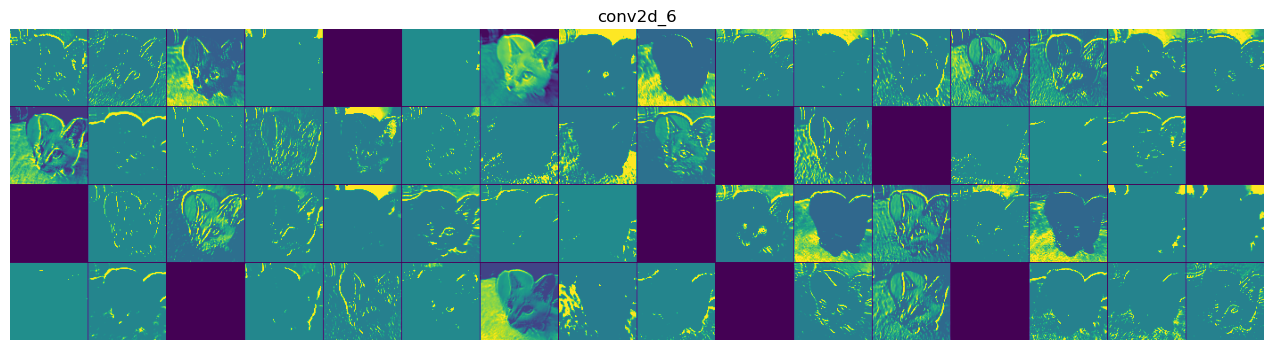

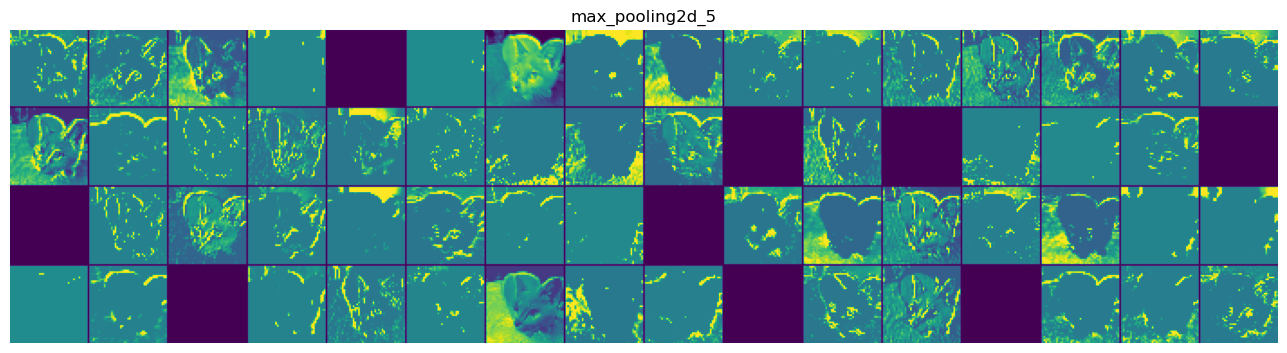

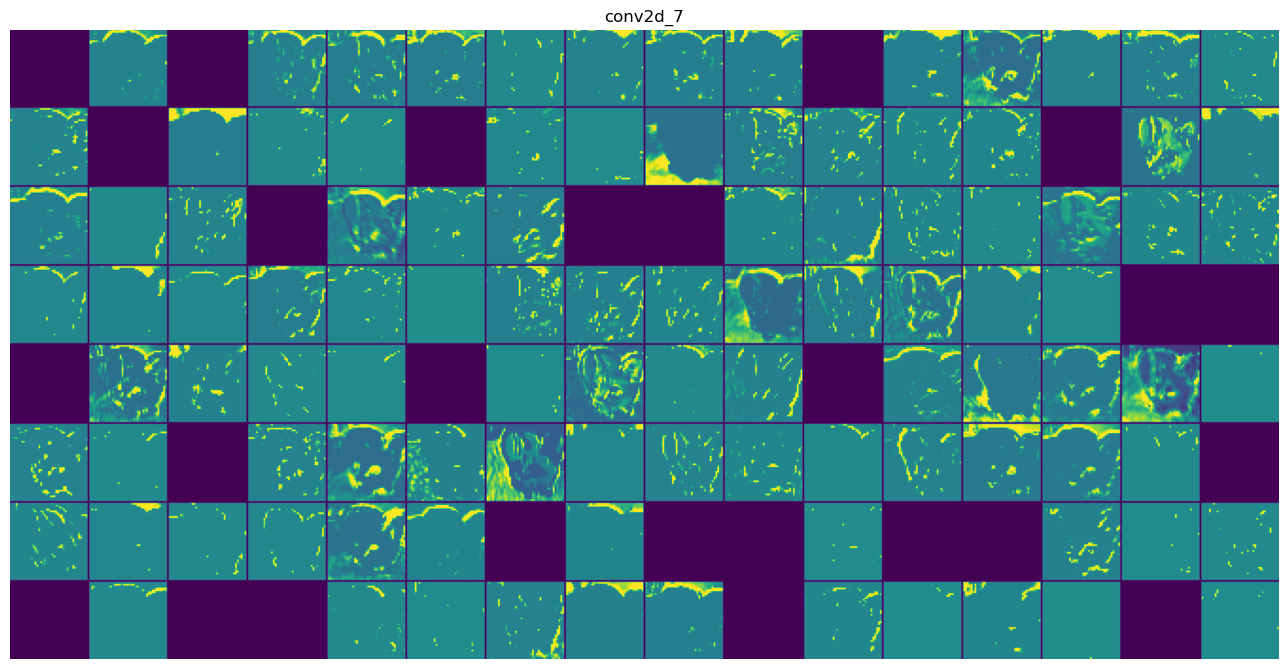

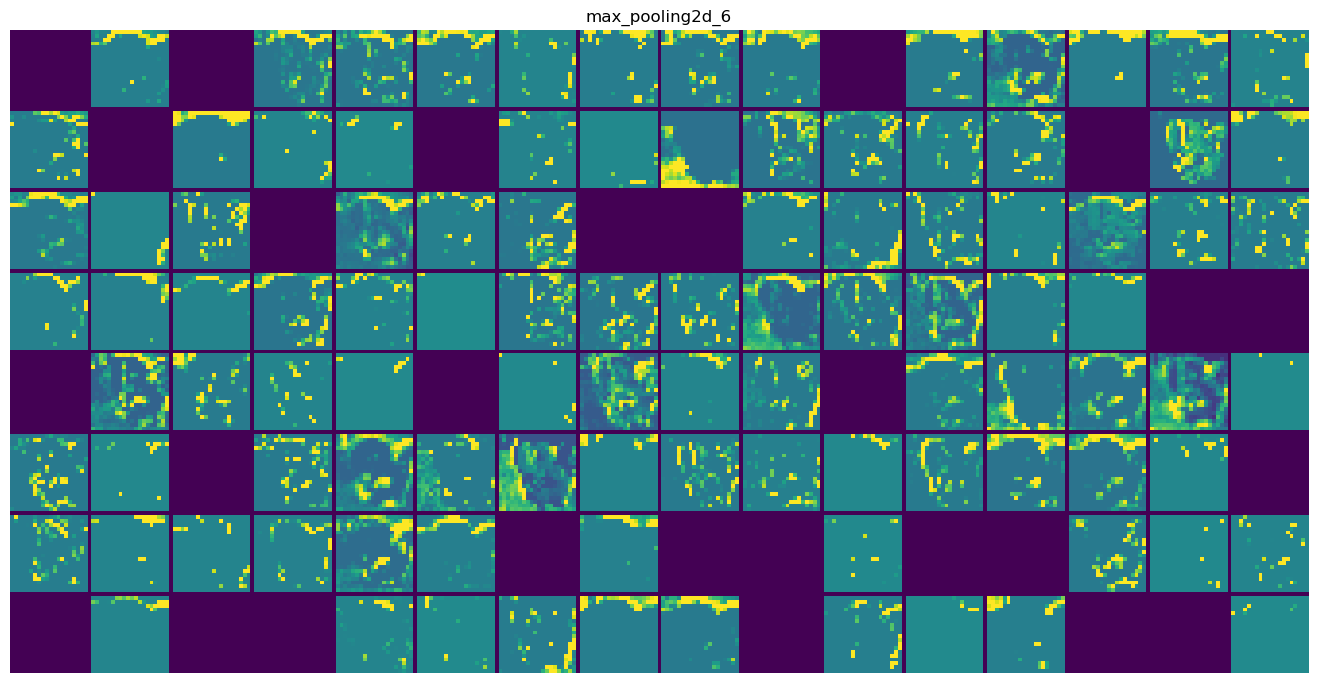

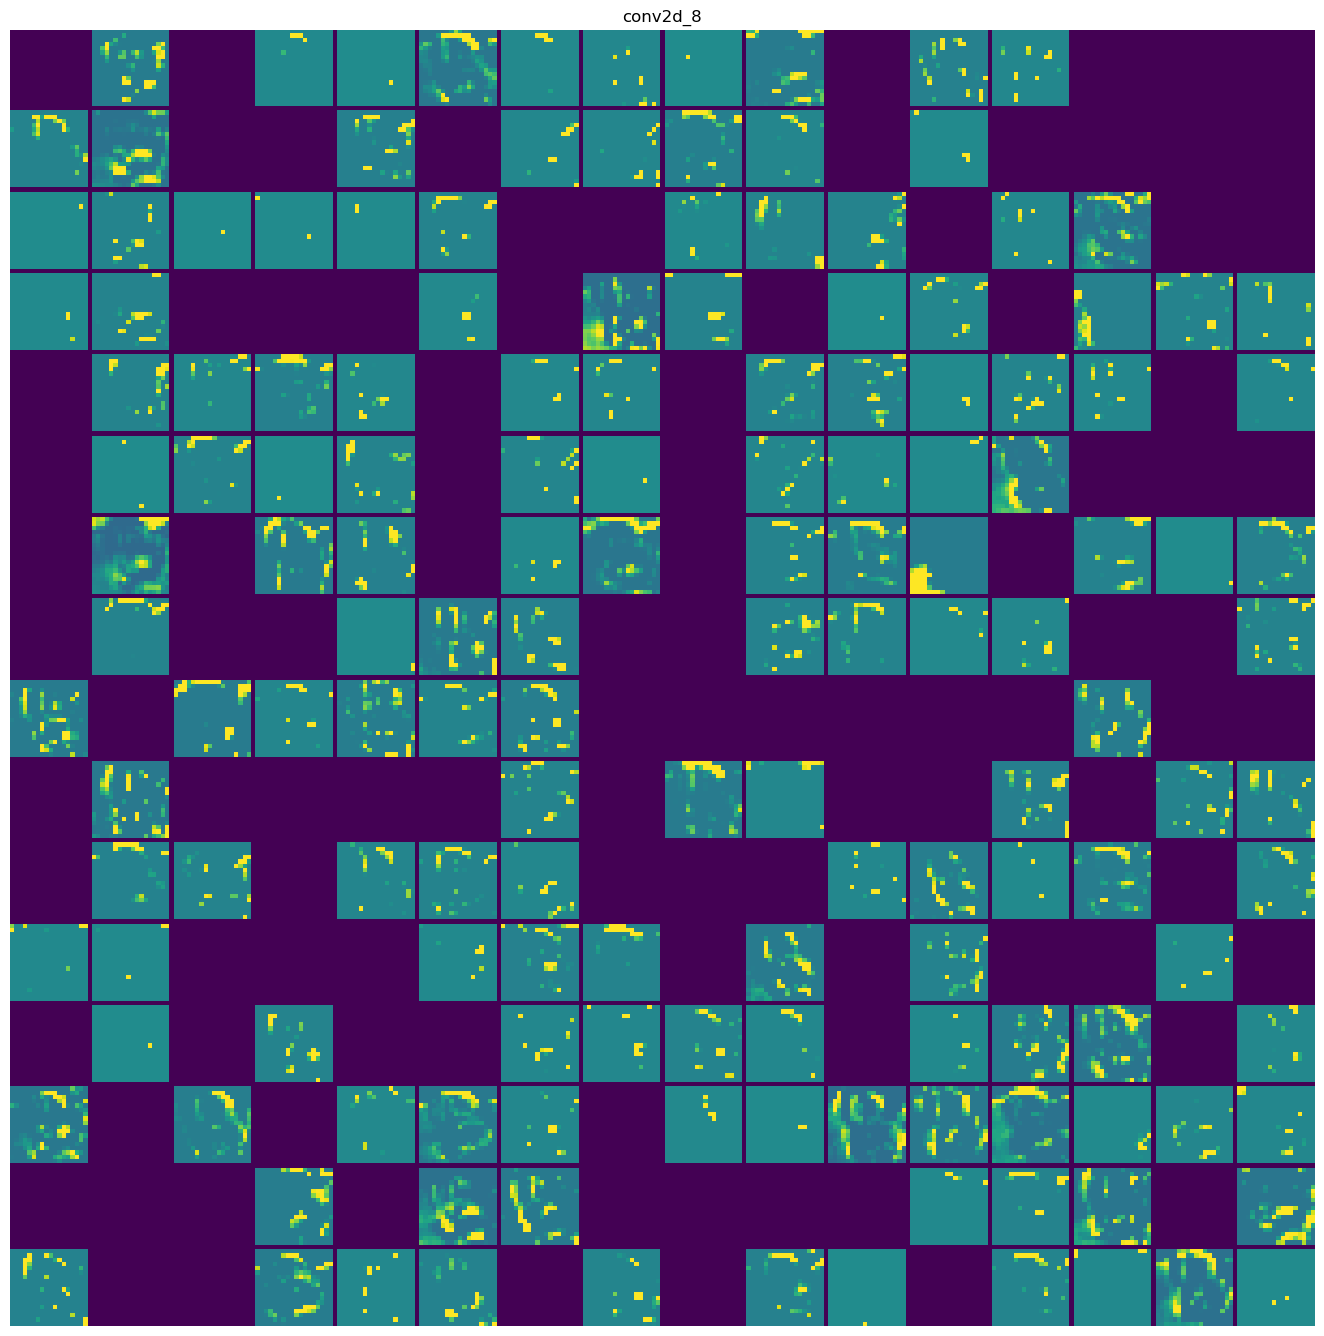

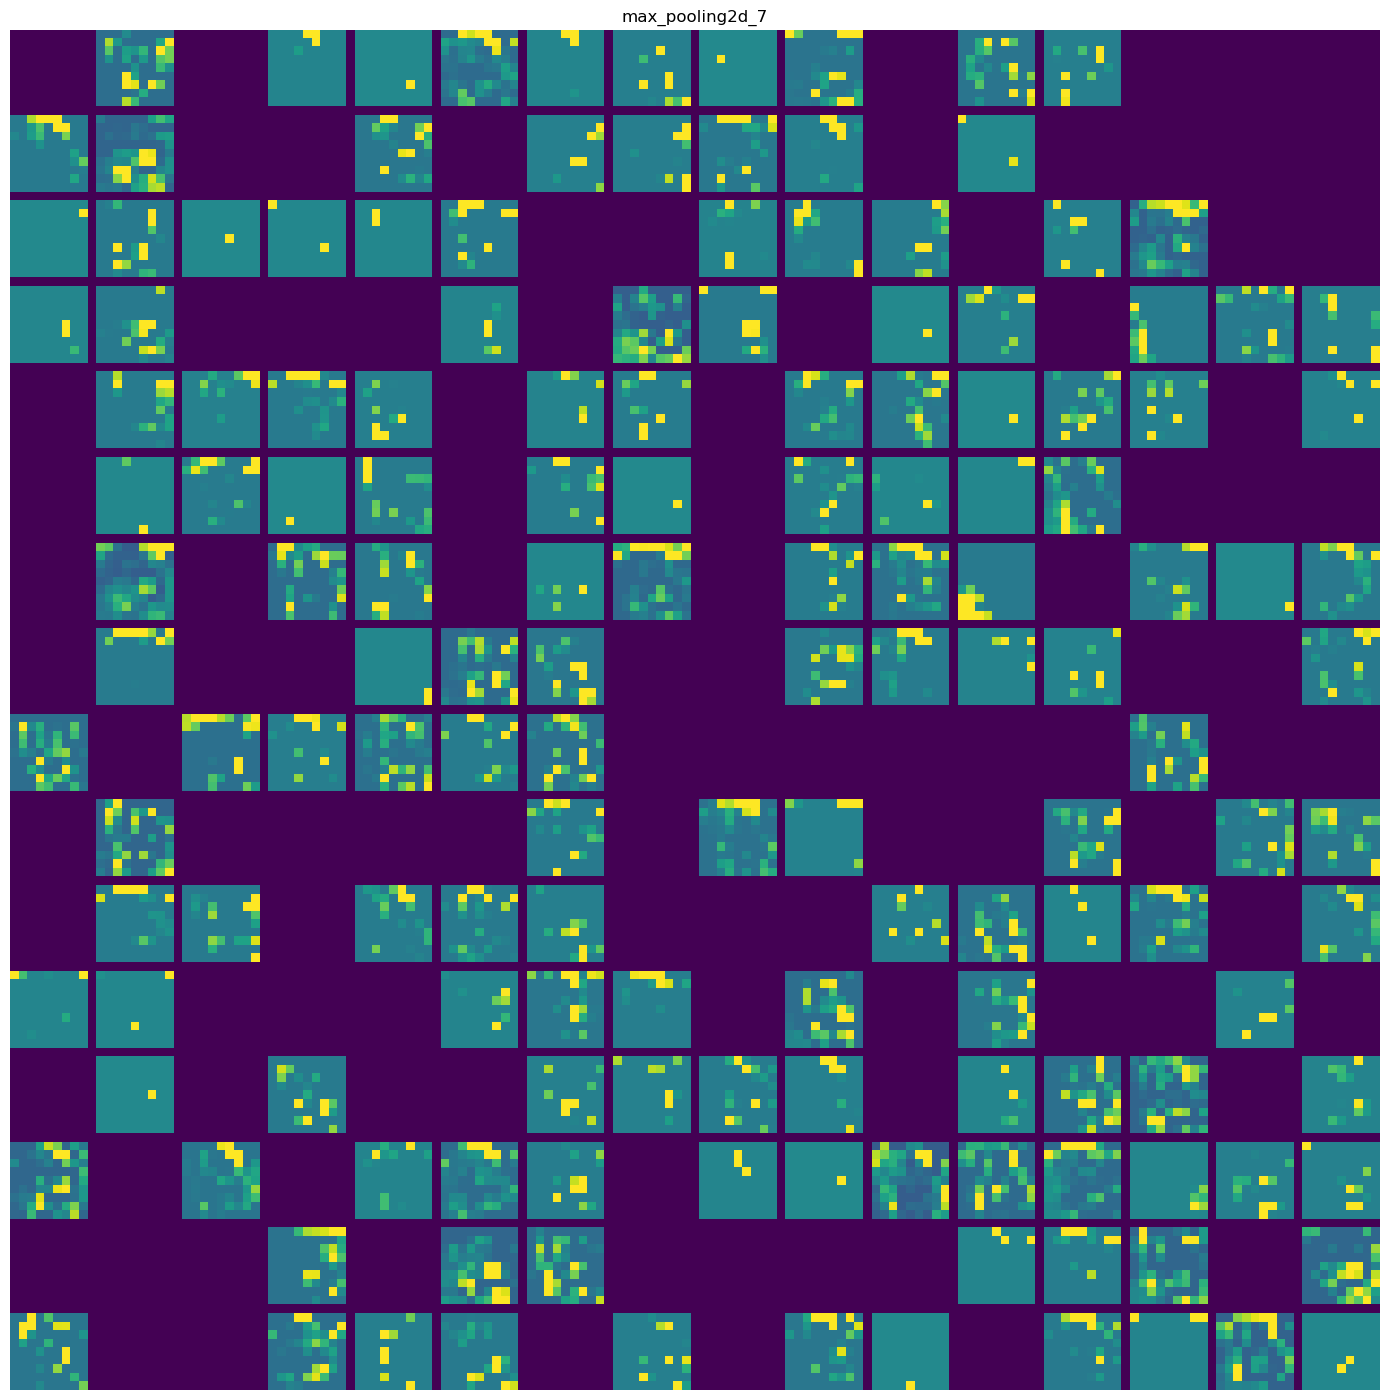

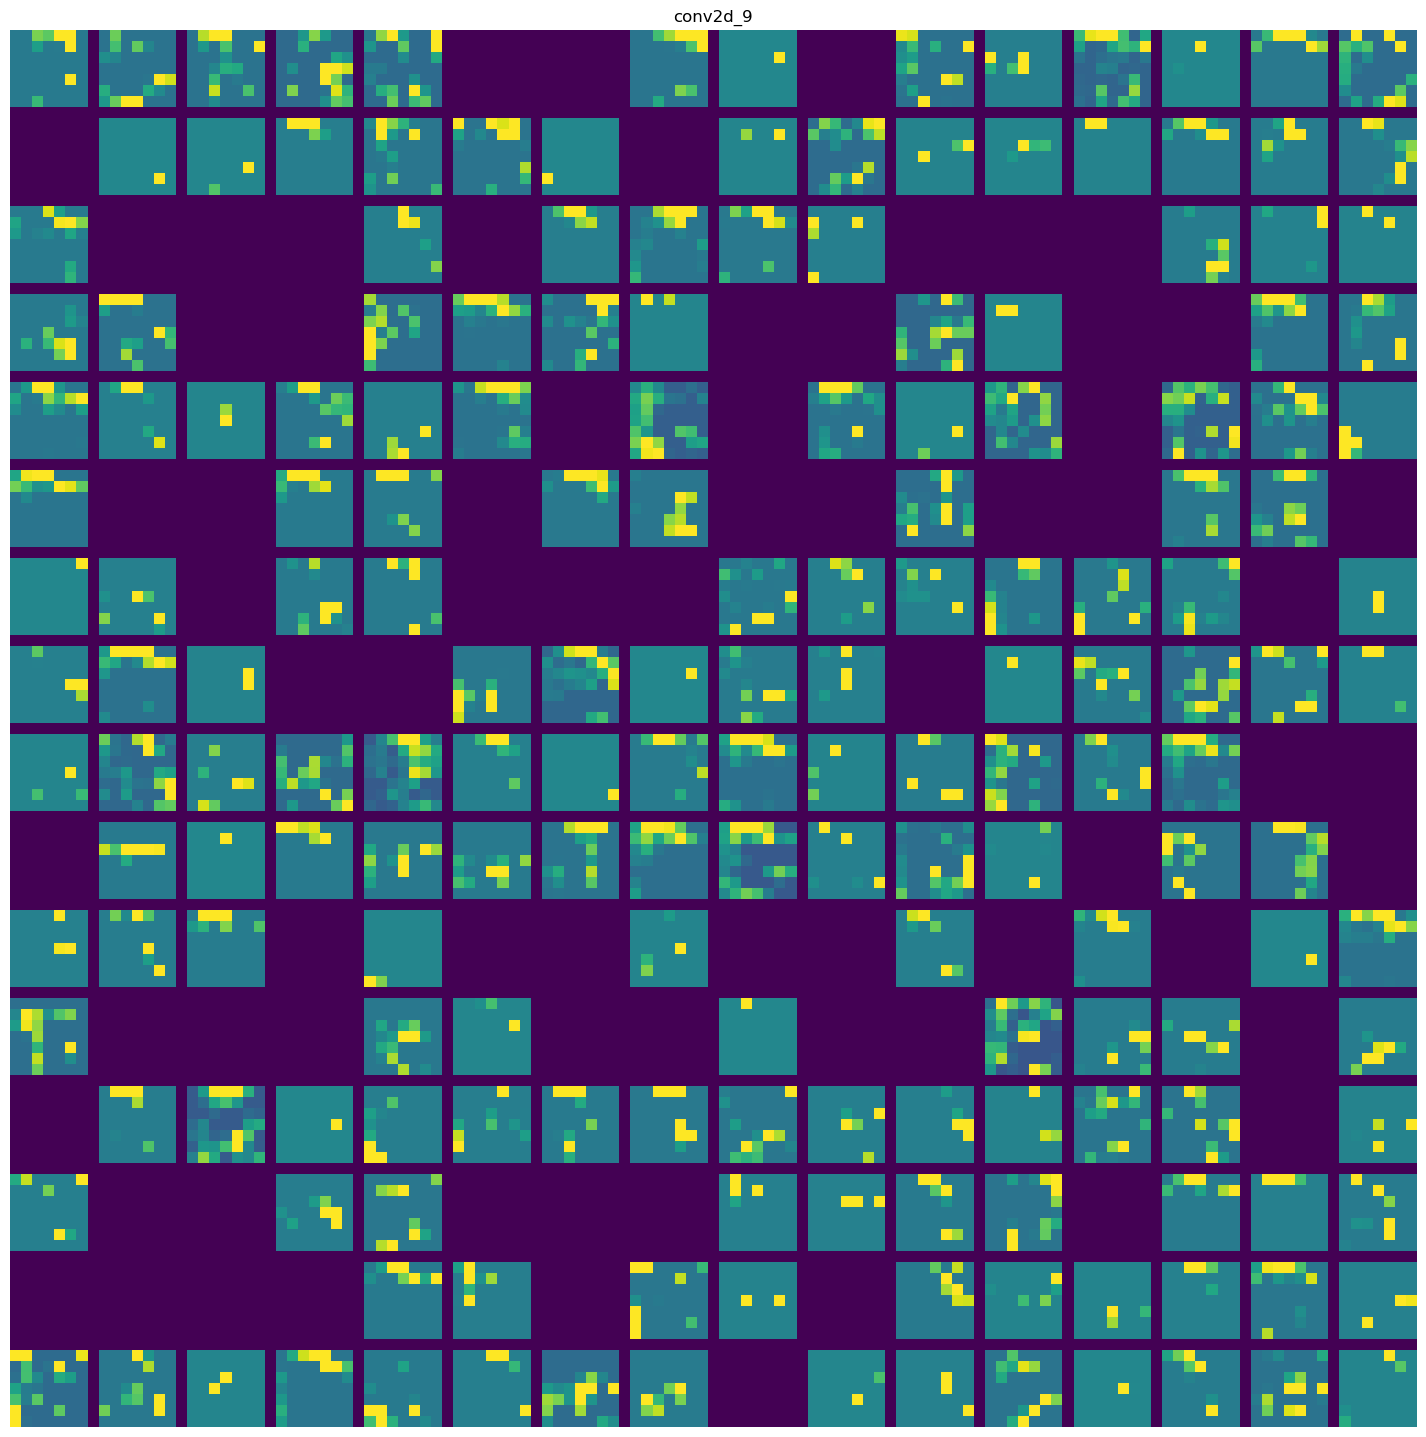

In [37]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

### Visualizing convnet filters

- Another easy way to inspect the filters learned by CNNs is to display the visual pattern that each filter is meant to respond to.
- This can be done with gradient ascent in input space: applying gradient descent to the value of the input image of a CNN so as to maximize the response of a specific filter, starting from a blank input image. The resulting input image will be one that the chosen filter is maximally responsive to.
- Let’s try this with the filters of the Xception model, pretrained on ImageNet. The process is simple: we’ll build a loss function that maximizes the value of a given filter in a given convolution layer, and then we’ll use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. This will be our second example of a low-level gradient descent loop leveraging the GradientTape object

#### Instantiating the Xception convolutional base

In [38]:
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

83683744/83683744 [==============================] - 12s 0us/step


#### Printing the names of all convolutional layers in Xception

In [39]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


#### Creating a feature extractor model

In [40]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

#### Using the feature extractor

In [42]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [43]:
import tensorflow as tf

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

#### Loss maximization via stochastic gradient ascent

In [44]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

#### Function to generate filter visualizations

In [45]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

#### Utility function to convert a tensor into a valid image

In [46]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

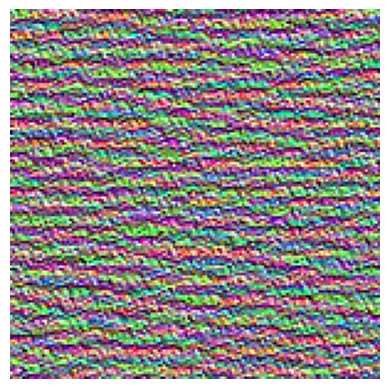

In [47]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

#### Generating a grid of all filter response patterns in a layer

In [48]:
all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

### Visualizing heatmaps of class activation

- This general category of techniques is called class activation map (CAM) visualization, and it consists of producing heatmaps of class activation over input images.
- **"Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization.**" Grad-CAM consists of taking the output feature map of a convolution layer, given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the channel. Intuitively, one way to understand this trick is to imagine that you are weighting a spatial map of "how intensely the input image activates different channels" by "how important each channel is with regard to the class," resulting in a spatial map of "how intensely the input image activates the class."



#### Loading the Xception network with pretrained weights

In [49]:
model = keras.applications.xception.Xception(weights="imagenet")

91884032/91884032 [==============================] - 13s 0us/step


#### Preprocessing an input image for Xception

In [50]:
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

733657/733657 [==============================] - 0s 0us/step


In [51]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 1us/step
[('n02504458', 'African_elephant', 0.8699273), ('n01871265', 'tusker', 0.07696834), ('n02504013', 'Indian_elephant', 0.023537153)]


In [52]:
np.argmax(preds[0])

386

#### Setting up a model that returns the last convolutional output

In [53]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

#### Reapplying the classifier on top of the last convolutional output

In [54]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

#### Retrieving the gradients of the top predicted class

In [55]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

#### Gradient pooling and channel-importance weighting

In [56]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

#### Heatmap post-processing

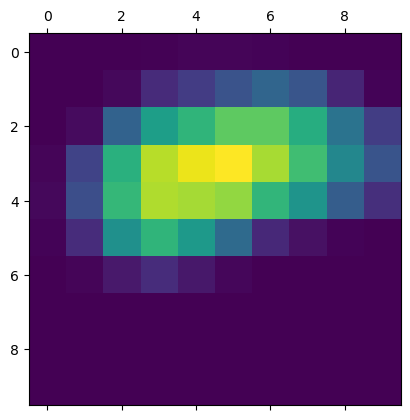

In [57]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

#### Superimposing the heatmap on the original picture

In [58]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

C:\Users\Sunday Okechukwu\AppData\Local\Temp\ipykernel_15040\780671328.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


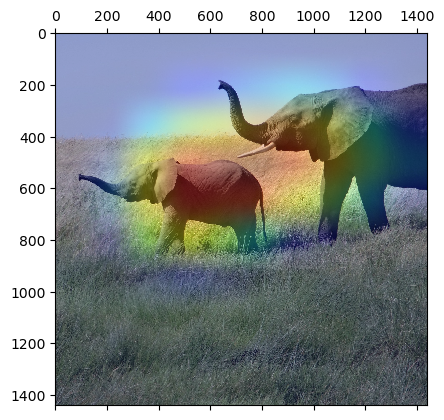

In [59]:
plt.matshow(superimposed_img)